# 实验三 循环神经网络的深度学习架构实现

### 1. 配置TensorFlow实验环境

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib.pyplot as plt 

def save_fig(fig_id, tight_layout=True, fig_extension="png", 
             resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution) 

#### 生成测试数据函数，绘制图形函数

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  
    #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) 
    # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   
    # + noise
    return series[..., np.newaxis].astype(np.float32)

### 2. 生成实验数据

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, 
                 label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")
        
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 
             "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 
             "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

Saving figure time_series_plot


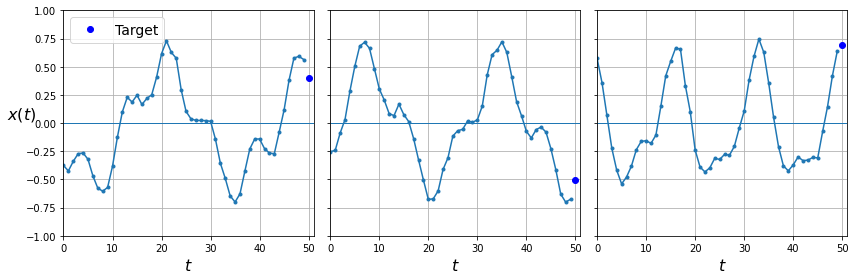

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

### 3. 线性预测模型

Epoch 1/20
219/219 [==============================] - 0s 820us/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 543us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 622us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 555us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 495us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 474us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 552us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 430us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 527us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 533us/step - loss: 0.006

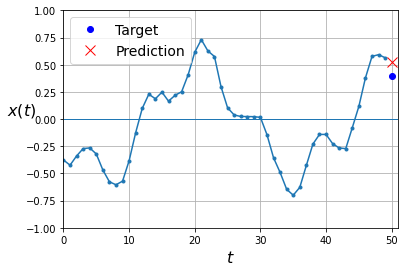

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))
model.evaluate(X_valid, y_valid)

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 4. 简单RNN模型

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0110

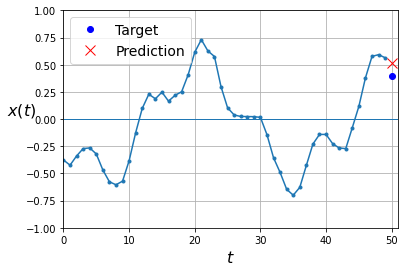

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))
model.evaluate(X_valid, y_valid)

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 5. 深度RNN模型

Epoch 1/20
219/219 [==============================] - 4s 13ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0035 - val_lo

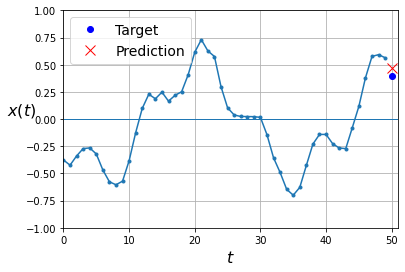

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 6. 多输出RNN模型​

Epoch 1/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0444 - val_loss: 0.0084
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0034 - val_loss: 0.0033

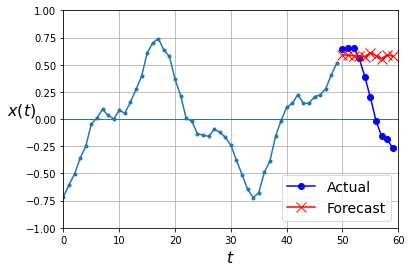

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### 7. 用循环神经网络完成对数据集MNIST的分类任务

#### 1） 配置运行环境

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

time_steps=28  # timesteps to unroll
n_units=128    # hidden LSTM units
n_inputs=28    # rows of 28 pixels (an mnist img is 28x28)
n_classes=10   # mnist classes/labels (0-9)
batch_size=128 # Size of each batch
n_epochs=5

#### 2）加载MNIST数据集

In [15]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

((x_train, y_train), (x_test, y_test)) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#### 3） 定义模型

In [16]:
model = Sequential()
model.add(LSTM(n_units, input_shape=(time_steps, n_inputs)))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 81,674
Trainable params: 81,674
Non-trainable params: 0
_________________________________________________________________


#### 4） 训练模型

In [17]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=False)

Epoch 1/5
469/469 [==============================] - 11s 21ms/step - loss: 0.6050 - accuracy: 0.8005
Epoch 2/5
469/469 [==============================] - 10s 21ms/step - loss: 0.1760 - accuracy: 0.9469
Epoch 3/5
469/469 [==============================] - 10s 22ms/step - loss: 0.1092 - accuracy: 0.9676
Epoch 4/5
469/469 [==============================] - 11s 23ms/step - loss: 0.0796 - accuracy: 0.9760
Epoch 5/5
469/469 [==============================] - 12s 25ms/step - loss: 0.0616 - accuracy: 0.9820


#### 5） 测试模型

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test,verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

313/313 - 1s - loss: 0.0753 - accuracy: 0.9766

Test accuracy: 0.9765999913215637

Test loss: 0.07530570775270462
